# Adversarial Examples

## If neural network models are as good as people say they are, why are they so easily fooled?

Research in AI and Machine Learning has a rich history of aiming to classify images. It makes sense, a computer classifying images well is both commercially useful and interesting to read about / see in action. From automatically tagging holiday photos for Instagram to setting up the foundations of a true surveilance state, there are many faucets from which one may extract worth in this field.

Within the last decade, you have likely heard someone say, or seen someone write something along the lines of "*Computers are better than humans at recognsing images*". A bold claim, but with [pocket sized technology accessible to consumers, that can identify the contents of images](https://www.theverge.com/2018/12/19/18149120/google-lens-ai-camera-recognize-detect-1-billion-items) it is easy to see where this comes from.

The graph below supports this idea, showing how in 2015 the first model was published that could defeat human classifcation accuracy in the ImageNet Image Classification Challenge.

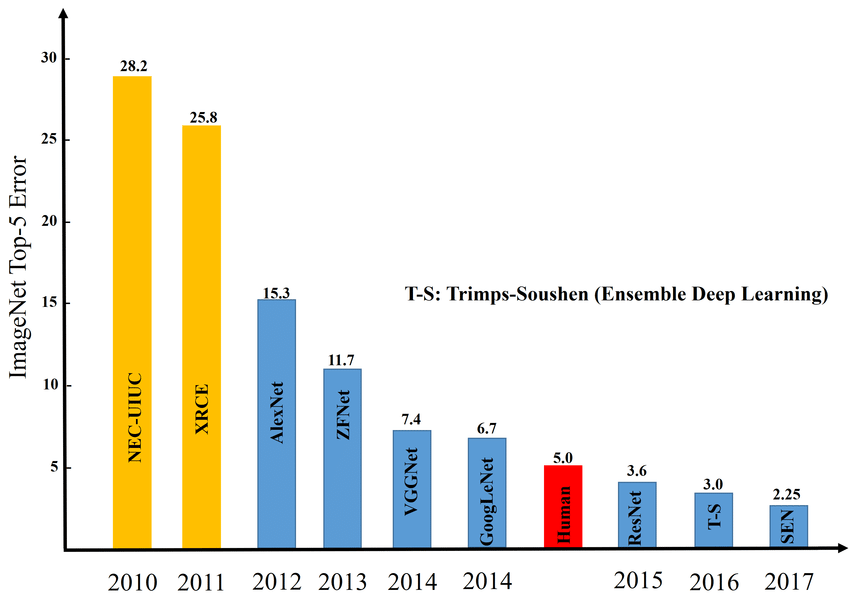
(note: Top-5 error refers to how often the correct answer was not within the top 5 guesses of each image classifier)

Impressive. I would forgive you for viewing this graph and thinking that 2015 was the year that shaped it all, that humanity should resign itself to its future status as second best to computers (at least in their ability to identify the subject of each arbitrary photo presented to them).

In 2015, one impressive model that came about and broke the "Human Level Classification" milestone, was Google's very own Inception-V3 classifier, with an impressive Top-5 Error of 3.7 (as outlined in [Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J. and Wojna, Z., 2016. Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).](https://arxiv.org/pdf/1512.03385.pdf)


However, if the Inception-V3 classifier is so imrpessive, why does this happen:

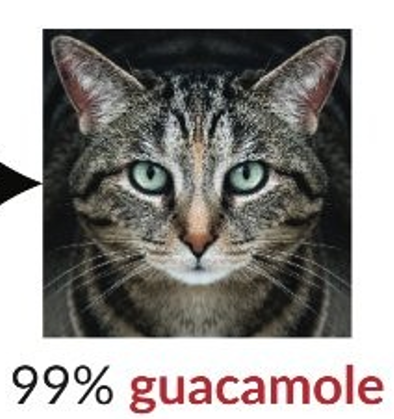

This is a destressing result. When presented with what is (hopefully) obviously a picture of a cat, the Inception classifier is convinced that this image is in fact of guacamole. No human you would consider intelligent would come to this conclusion? surely?

I will dive into the origin of this result later, but in the meantime lets go back to basics and talk about how we train neural networks.

## In broad strokes, what goals might one set out when training an image classifier? How might they achieve them?

It does seem sensible that when training an image classifier, the goal set out is to reduce the error of the model against the training dataset. If one is doing this with a neural network, we have the ever handy tool of backpropagation to achieve this - and use gradient descent to <b>minimise</b> the error of the model. This is hopefully a familiar concept, and the crux of how we aim to train many models. 

But can we adapt this concept to create a network, that instead of aiming to create a model which is good at classification, aims to create an image that is very hard to classify?

As outlined in [Szegedy, C., Zaremba, W., Sutskever, I., Bruna, J., Erhan, D., Goodfellow, I. and Fergus, R., 2013. Intriguing properties of neural networks. arXiv preprint arXiv:1312.6199.](https://arxiv.org/pdf/1312.6199.pdf) this can be achieved quite simply by minorly altering images in a way that aims to <b>maximise</b> the error of the model.

What does this look like in practice?

In [1]:
# I will start by importing some libraries I will need, we will be using PyTorch as our weapon of choice to build these networks

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms, models


import matplotlib.pyplot as plt

import numpy as np
import json



In [2]:
# I will now load in the inception_v3 model, and using it for all these examples

model = models.inception_v3(pretrained=True)

device = torch.device("cuda") # I am blessed with a CUDA gpu

model.to(device)
model.eval() #stops us acidentally altering the model, "finalising" it

print("Loaded inception model")

Loaded inception model


Here is the code I will be using to load in my example images. I have chosen 9 images of candles. You can also see that Inception-V3 classifies them all correctly as such.

In [17]:
loader = transforms.Compose([transforms.Resize([299, 299]), transforms.ToTensor()])

def load_dataset():
    data_path = 'data'
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=loader
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=7,
        num_workers=0,
        shuffle=True
    )
    return train_loader

for data, target in load_dataset():
    data = data.cuda()
    output = model(data)

predictions = torch.max(output.data, 1)[1].cpu().numpy()

with open("imagenet_class_index.json", "r") as classes:
    class_idx = json.load(classes)
    for p in predictions:
        print(class_idx[str(p)][1])

candle
candle
candle
candle
candle
candle
candle


Here is a function that takes an image, an epsilon (small value) and gradient. We can make the image more erroneous by moving its values(pixels) in the direction of its gradient.  

In [18]:
def create_adversary(image, epsilon, gradient):
    
    # This is the important line, rather than performing a "gradient descent", minimising error
    # I am performing a gradient ascent, altering the image a little, and making it "climb"
    # That gradient as best it can, maximising the error!
    perturbed_image = image + epsilon * gradient
    
    # this just makes sure that the image values are still within its boundaries
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
  
    return perturbed_image

We can iteratively apply this function, and "nudge" the images of candles towards being more erroneous... The code below will load images, alter them by a small value in the direction of their gradient... until it has generated an example that is misclassified! we can store this image and classification to view with our own eyes what has changed (or not)

In [19]:
epsilon = 0.1
target_class = 470 # A candle
batch_size = 7


t = [target_class] * batch_size

output = None

example_found = [False] * batch_size
adversarial_examples = [None] * batch_size
prediction_names = [None] * batch_size

num_found = 0


with open("imagenet_class_index.json", "r") as classes:
    class_indexes = json.load(classes)

# Loop over all examples in test set
count = 0
for data, target in load_dataset():
    
    target = torch.LongTensor(t)
    
    while num_found < 7:
        count += 1
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero  gradients
        model.zero_grad()

        # Calculate gradient
        loss.backward()
        
        data_grad = data.grad.data
 
        # Attempt to create an adversary
        perturbed_data = create_adversary(data, epsilon, data.grad)
        
        if not output is None:
            predictions = torch.max(output.data, 1)[1].cpu().numpy()
            for ii in range(len(predictions)):
                if example_found[ii] != True and predictions[ii] != target_class:
                    adversarial_examples[ii] = data[ii].cpu().detach().permute(1, 2, 0)
                    example_found[ii] = True
                    prediction_names[ii] = class_indexes[str(predictions[ii])][1]

                    num_found = 0
                    for found in example_found:
                        if found:
                            num_found += 1
                    
                    print(num_found, "adversarial examples have been found after", count, "iterations")
        
        data = perturbed_data.clone().detach()

        # Re-classify the perturbed image
        output = model(perturbed_data)

1 adversarial examples have been found after 3 iterations
2 adversarial examples have been found after 7 iterations
3 adversarial examples have been found after 20 iterations
4 adversarial examples have been found after 26 iterations
5 adversarial examples have been found after 27 iterations
6 adversarial examples have been found after 33 iterations
7 adversarial examples have been found after 59 iterations


We have found some adversarial examples based on each of the supplied images of candles! This function "inception_thinks" will show us the adversarial image, and what the Inception classifier thinks the image is of.

In [20]:
def inception_thinks(idx):
    plt.imshow(adversarial_examples[idx])
    plt.axis('off')
    print("Inception-V3 thinks that this is an image of a", prediction_names[idx])

Inception-V3 thinks that this is an image of a jack-o'-lantern


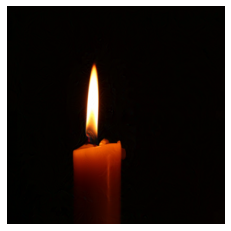

In [21]:
inception_thinks(0)

Inception-V3 thinks that this is an image of a matchstick


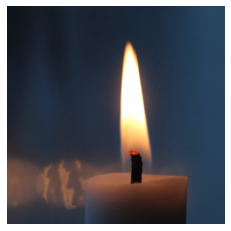

In [22]:
inception_thinks(1)

Inception-V3 thinks that this is an image of a lighter


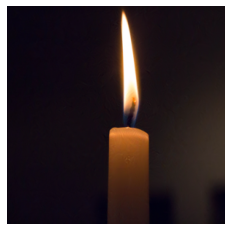

In [23]:
inception_thinks(2)

Inception-V3 thinks that this is an image of a table_lamp


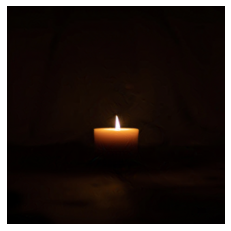

In [24]:
inception_thinks(3)

Inception-V3 thinks that this is an image of a matchstick


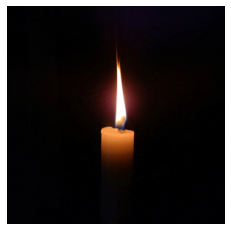

In [25]:
inception_thinks(4)

Inception-V3 thinks that this is an image of a lighter


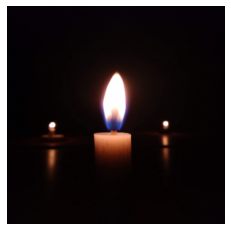

In [26]:
inception_thinks(5)

Inception-V3 thinks that this is an image of a matchstick


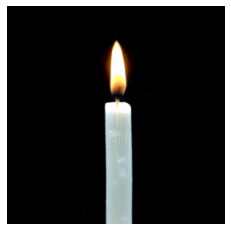

In [27]:
inception_thinks(6)

It is hopefully self evident that these are still images of candles. They have just been (ever so slightly) altered. You may be able to notice a few erroneous pixels here and there if you zoom in, but this really is subtle.

Surely if an image classifier "understands" images, it should be able to tell an image of a candle with a few pixels altered, is still an image of a candle.

## Can we take this further?

One way of taking this further would be to be able to target what we want the adversary to be classified as. We can achieve this by doing similar to before, but rather than maximising error, we <b>minimise error against a false target class</b>. 

In this example I will demonstrate altering images of candles so that Inception believes them to be Mittens. (based off of work from [Athalye, A., Engstrom, L., Ilyas, A. and Kwok, K., 2017. Synthesizing robust adversarial examples. arXiv preprint arXiv:1707.07397.](https://arxiv.org/pdf/1707.07397.pdf))

Feel free to change the "target_class" value below to an amusing class of your choice. This will work with any target class (with varying degrees of success)

In [29]:
def create_targeted_adversary(image, epsilon, gradient):
    
    # Similar to before, but now we are minimizing error!
    perturbed_image = image - epsilon * gradient
    
    # this just makes sure that the image values are still within its boundaries
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
  
    return perturbed_image

In [31]:
epsilon = 0.1
target_class = 658 # Mittens
batch_size = 7


t = [target_class] * batch_size

output = None

example_found = [False] * batch_size
adversarial_examples = [None] * batch_size
prediction_names = [None] * batch_size

num_found = 0


with open("imagenet_class_index.json", "r") as classes:
    class_indexes = json.load(classes)

# Loop over all examples in test set
count = 0
for data, target in load_dataset():
    
    target = torch.LongTensor(t)
    
    while num_found < 7:
        count += 1
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero  gradients
        model.zero_grad()

        # Calculate gradient
        loss.backward()
        
        data_grad = data.grad.data
 
        # Attempt to create a targeted adversary
        perturbed_data = create_targeted_adversary(data, epsilon, data.grad)
        
        if not output is None:
            predictions = torch.max(output.data, 1)[1].cpu().numpy()
            for ii in range(len(predictions)):
                if example_found[ii] != True and predictions[ii] == target_class:
                    adversarial_examples[ii] = data[ii].cpu().detach().permute(1, 2, 0)
                    example_found[ii] = True
                    prediction_names[ii] = class_indexes[str(predictions[ii])][1]

                    num_found = 0
                    for found in example_found:
                        if found:
                            num_found += 1
                    
                    print(num_found, "adversarial examples have been found after", count, "iterations")
        
        data = perturbed_data.clone().detach()

        # Re-classify the perturbed image
        output = model(perturbed_data)

1 adversarial examples have been found after 138 iterations
2 adversarial examples have been found after 142 iterations
3 adversarial examples have been found after 233 iterations
4 adversarial examples have been found after 237 iterations
5 adversarial examples have been found after 268 iterations
6 adversarial examples have been found after 295 iterations
7 adversarial examples have been found after 667 iterations


Inception-V3 thinks that this is an image of a mitten


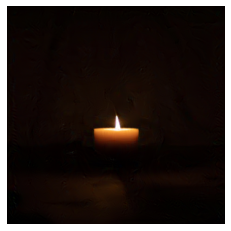

In [33]:
inception_thinks(0)

Inception-V3 thinks that this is an image of a mitten


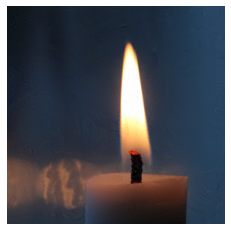

In [34]:
inception_thinks(1)

Inception-V3 thinks that this is an image of a mitten


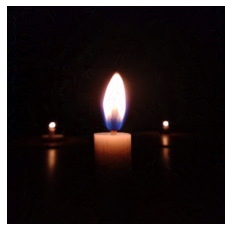

In [35]:
inception_thinks(2)

Inception-V3 thinks that this is an image of a mitten


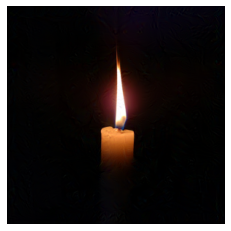

In [36]:
inception_thinks(3)

Inception-V3 thinks that this is an image of a mitten


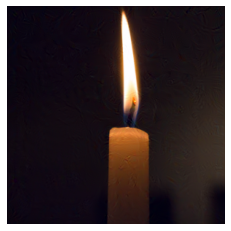

In [37]:
inception_thinks(4)

Inception-V3 thinks that this is an image of a mitten


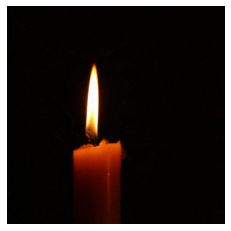

In [38]:
inception_thinks(5)

Inception-V3 thinks that this is an image of a mitten


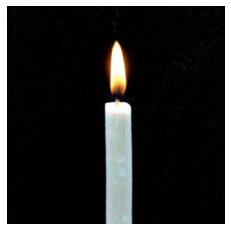

In [39]:
inception_thinks(6)

As you can see, with your own eyes... every image has been classified as a mitten, but still looks an afwul lot like a candle, right?

This concept is actually taken further in the "Robust Adversarial Examples" paper, where the team of researchers actually manufature a "Real World Adversarial Example" and create a model of a [turtle that inception believes is a rifle](https://youtu.be/XaQu7kkQBPc)

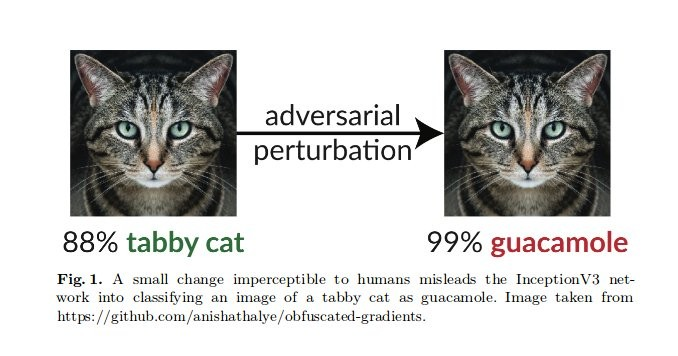 (the earlier presented cat-guacamole image was based on the same research)

## Why is this all so important? What does it mean for the field of AI and Machine Learning?

As mentioned earlier, I would not blame someone for thinking that image classification models are "better" than humans at classification. And when looking at error comparisons, that may hold true. But these examples show that there are some gaping holes in Inception's ability to "understand" an image, despite it's error being superior to human levels.

There has been some great research done since this issue was discovered, such as [You, Z., Ye, J., Li, K., Xu, Z. and Wang, P., 2019, September. Adversarial noise layer: Regularize neural network by adding noise. In 2019 IEEE International Conference on Image Processing (ICIP) (pp. 909-913). IEEE.](https://arxiv.org/pdf/1805.08000.pdf) where researchers realised that adding noise to the model could increase the robustness of a model and help defend against adversarial attacks.

After coming so far with error rates, ensuring that models we create in the future do not make these sorts of errors in the future may well get us closer to creating classifier that truly outperform human understanding.